In [1]:
from __future__ import division
from numpy import pi, linspace, sin, cos, exp, log, sqrt, dot
from numpy.linalg import norm
import numpy.random as rnd
import random


import numpy as np
import matplotlib.pyplot as plt
#import theano as T

%matplotlib inline

sigmoid = lambda x: 1/(1+np.exp(-x))

In [2]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

<h1> Write own neural network code </h1>

In [22]:
""" Multi Layer Perceptron"""


class multilayer_perceptron(object):
    
    

    
    def __init__(self,units_per_layer,activation='sigmoid',costF='quadratic'):
        self.num_layers = len(units_per_layer)
        self.biases = [np.random.randn(y, 1) for y in units_per_layer[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(units_per_layer[:-1], units_per_layer[1:])]

        if activation=='sigmoid':
            self.activation = lambda x: 1./(1.+np.exp(-x))
            self.activation_deriv = lambda x: sigmoid(x)*(1-sigmoid(x))
        else:
            raise ValueError
            
        if costF=='cross_entropy':
            self.costF = lambda a,y: 1/len(a) * np.sum(y*np.log(a) + (1-y)*np.log(1-a))
            self.get_output_delta = lambda a,y,z: (a-y)
        elif costF=='quadratic':
            self.costF = lambda a,y: 1/len(a) * np.sum(norm(x-y)**2)
            self.get_output_delta = lambda a,y,z: ((a-y)*
                                            self.activation_deriv(z))



    def forwardpass(self, a):
        """Return the output of the network if 'a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = self.activation(np.dot(w, a)+b)
        return a

        
        
    def miniBatch_backprop(self,network_inputs,target_activation):

            #print network_inputs.shape[1]
            delta_cost_biass = [np.zeros(list(b.shape) + [network_inputs.shape[1]]) for b in self.biases]
            delta_cost_weights = [np.zeros(list(w.shape) + [target_activation.shape[1]]) for w in self.weights]
            weighted_activations = []; 
            a = network_inputs
            activations = [a]
            "first perform the forward pass"
            for b, w in zip(self.biases, self.weights):
                z = np.dot(w, a)+b 
                weighted_activations.append(z)
                a = sigmoid(z)
                activations.append(a)
                
                
            "calculate the ouput errors"
            delta = self.get_output_delta(activations[-1],target_activation,weighted_activations[-1])
            
            
            
            delta_cost_biass[-1] = np.array([delta.sum(axis=1)]).T
            delta_cost_weights[-1] = np.einsum('ik,jk->kij', delta, activations[-2]).sum(axis=0)


            for l in xrange(2,self.num_layers):
                delta = np.dot(self.weights[-l+1].T,delta)*self.activation_deriv(weighted_activations[-l])
                delta_cost_biass[-l] = np.array([delta.sum(axis=1)]).T
                delta_cost_weights[-l] =  np.einsum('ik,jk->kij', delta, activations[-l-1]).sum(axis=0)

            return delta_cost_weights, delta_cost_biass

        
    
    def minibatch_weight_update(self,mini_batch,eta):

        delta_cost_biass = [np.zeros(b.shape) for b in self.biases]
        delta_cost_weights = [np.zeros(w.shape) for w in self.weights]
        
        #recursive for calculating errors over training examples
        n_examples = len(mini_batch)
        
        
        x_data = np.squeeze(np.array([mini_batch[i][0] for i in range(n_examples)])).T
        y_data = np.squeeze(np.array([mini_batch[i][1] for i in range(n_examples)])).T
        

        delta_cost_weights, delta_cost_biass = self.miniBatch_backprop(x_data,y_data)
        
       
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, delta_cost_weights)]
        #print b.shape, nb.shape
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, delta_cost_biass)]
    
    def stochastic_gradient_descent(self, training_data, epochs, mini_batch_size, eta,test_data=None):
        
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                #print [i.shape for i in self.biases]
                self.minibatch_weight_update(mini_batch, eta)
                #print 'ho'
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)
    
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.forwardpass(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
    
                
                
                

In [23]:
mlp = multilayer_perceptron([784, 30, 10],costF='quadratic')
mlp.stochastic_gradient_descent(training_data, 3, 20, 3.0, test_data=test_data)

Epoch 0: 8838 / 10000
Epoch 1: 9133 / 10000
Epoch 2: 9238 / 10000


<h1> Mnist Visualisation </h1>

In [27]:
n_examples = len(training_data)
x_data = np.array([training_data[i][0] for i in range(n_examples)])
y_data = np.array([training_data[i][1] for i in range(n_examples)])
x_data = np.squeeze(x_data).T

49


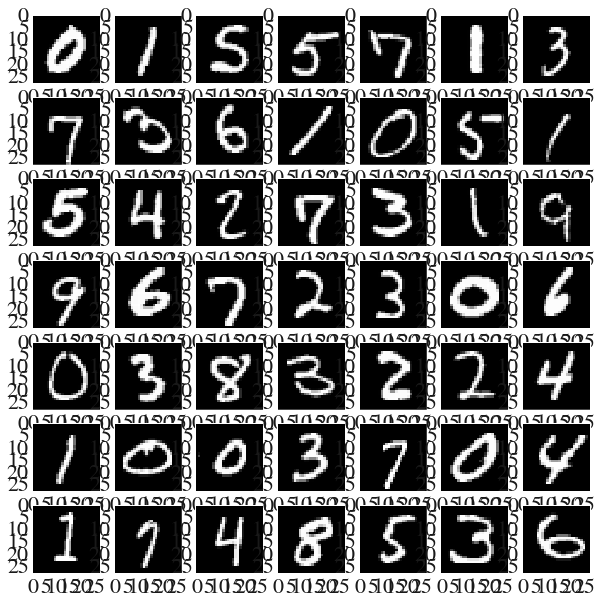

In [25]:
plt.figure(figsize=(10,10))


k = 1 
for i in range(1,8):
    for j in range(1,8):
        plt.subplot(7,7,k)
        plt.imshow(x_data[:,k].reshape(28,28),cmap='binary_r',interpolation='none')
        plt.grid()
        plt.yticks()
        k+= 1
print i*j

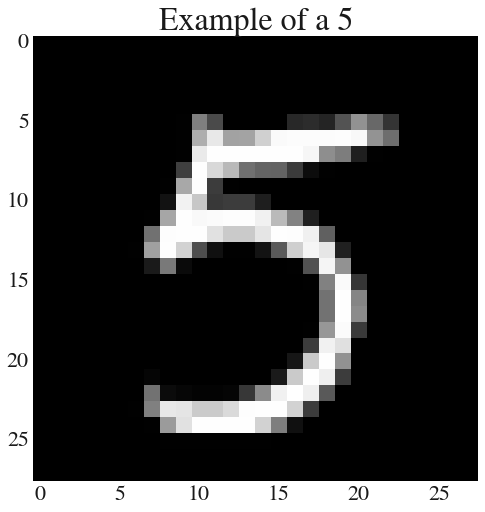

In [38]:
plt.figure(figsize=(8,8))
rndInt = np.random.randint(n_examples)
plt.title('Example of a %s' %np.where(y_data[rndInt])[0][0])
plt.imshow(x_data[:,rndInt].reshape(28,28),cmap='binary_r',interpolation='none')
plt.grid()

In [68]:
puy = np.arange(8000).reshape(20,400)
puy2 = np.arange(12000).reshape(30,400)

#print puy, '\n'
#print puy2.T

zz = np.zeros([400,20,30])

for i in range(400):
    zz[i,:,:] = np.dot(np.array([puy[:,i]]).T,
                np.array([puy2.T[i,:]]))

In [82]:
%%timeit
arty = np.einsum('ik,jk->kij', puy, puy2)

1000 loops, best of 3: 281 µs per loop


In [83]:
%%timeit
art = (puy[None,:,:]*puy2[:,None,:]).T

1000 loops, best of 3: 318 µs per loop


In [81]:
(art==arty).all()

True

In [52]:
art

array([[[ 0,  0,  0],
        [ 0, 16, 32]],

       [[ 1,  5,  9],
        [ 5, 25, 45]],

       [[ 4, 12, 20],
        [12, 36, 60]],

       [[ 9, 21, 33],
        [21, 49, 77]]])

In [53]:
arty

True